# Demonstration of adding an inset map using GeoPandas

This is an extension to the core GeoPandas material contained in the notebook geopandas_1_blank.ipynb. 

In this notebook we will cover:

1. Creating an inset map of Isles of Scilly, within a main map of Devon & Cornwall
1. Adding a common styling to both maps

This notebook uses a shapefile as the only input. The repository for this notebook (https://github.com/michaelallen1966/2010_geopandas) contains all the necessary files. UK government pages to download these files tend to move around! At the time of writing the full England shape file download may be found at:

https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-boundaries-ew-bsc

*With thanks to Tom Monks for kindly sharing his code on inset maps, upon which this notebook is based https://github.com/TomMonks*

## Installation

It is recommended that you install the environment as instructed in the README for this GitHub repository. You may also install packages manually ina current environment, though this method risks contability problems with your current environment. To install manually:

```
conda install geopandas pysal
conda install -c conda-forge geoplot
pip install contextily mapclassify
```

Alternative save the following as a file titled `environment.yml`:

```
name: geopandas
channels:
  - defaults
  - conda-forge
dependencies:
  - geopandas
  - geoplot
  - jupyterlab
  - pysal
  - pip
  - pip:
    - contextily
    - mapclassify
```

Then, from the folder where that yml file is, type the following into a terminal/command line: 

`conda env create -f environment.yml`

And then activate the environment with:

`conda activate geopandas`

And then launch Jupyter Lab with:

`jupyter-lab`


## Import modules

In [1]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, 
                                                   InsetPosition,
                                                   mark_inset)

## Load LSOA shape file

The following code will load the shapefile of the South West of England LSOAs (Lower Super Output Areas) into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

* EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
* EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).

This file is a clipped section of LSOAs that fall within the 5 police forces in the South West of England. In this notebook we will further restrict it to Devon, Cornwall and Isles of Scilly.

In [2]:
# Import LSOA Shape file that contains LSOAs for the SW England (use 'zip://'' prefic for zip files)
filename = "zip://./data/LSOA_2011_sw5forces_BGC_V2.zip"#zip://./data/south_west_lsoa.zip"
lsoa_gdf = geopandas.read_file(filename, crs='EPSG:27700')

A GeoPandas DataFrame has a 'geometry' column which contains the geographical details used for plotting and other geographic methods.

Let's look at the first 3 rows of our GeoPandas DataFrame.

In [3]:
lsoa_gdf.head(3)

,LSOA11CD,LSOA11NM,LSOA11NMW,Area,geometry
0,E01014370,Bath and North East Somerset 007A,Bath and North East Somerset 007A,374339,"POLYGON ((375207.458 165659.881, 375312.807 16..."
1,E01014371,Bath and North East Somerset 007B,Bath and North East Somerset 007B,410758,"POLYGON ((375613.903 165217.218, 375635.000 16..."
2,E01014372,Bath and North East Somerset 007C,Bath and North East Somerset 007C,164486,"POLYGON ((375273.457 165743.254, 375335.280 16..."


We can create a simple plot using the `plot()` method for the Geopandas DataFrame.

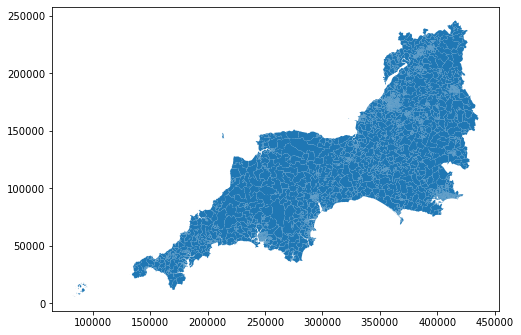

In [4]:
lsoa_gdf.plot(figsize=(8,8));

## Creating a map of just Devon, Cornwall & Isles of Scilly

Let's create a separate geopandas dataframe for the polygons that are in either Devon, Cornwall or Isles of Scilly.

We can do that by making use of the field LSOA11NM that has contains the string "Isles of Scilly" for the Isles of Scilly features, and "Cornwall", "Devon", "Torbay", "Plymouth", "Torridge", "Teignbridge" & "Exeter" for Devon and Cornwall.

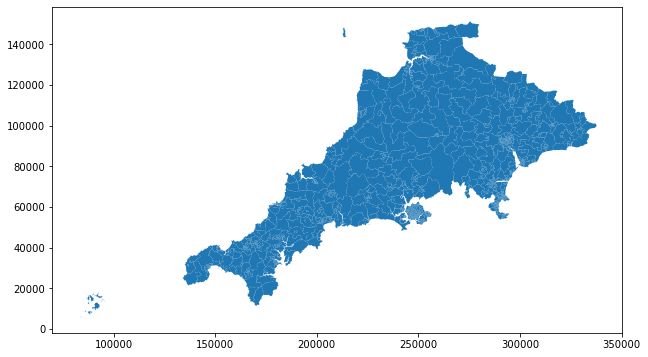

In [5]:
#create a new GeoDataFrame containing only Devon, Cornwall, & Isles of Scilly LSOAs
region = "Cornwall|Devon|Torbay|Plymouth|Torridge|Teignbridge|Exeter|Isles of Scilly"
mask = lsoa_gdf['LSOA11NM'].str.contains(region)
dc_ios_lsoa_gdf = lsoa_gdf[mask]
dc_ios_lsoa_gdf.plot(figsize=(12,6));

Due to the location of the Isles of Scilly in relation to Devon & Cornwall, the map contains a lot of white space. It would be a better use of space if we included the Isles of Scilly as an inset map. 

## Creating a map of Devon, Cornwall & Isles of Scilly, using an inset map for the Isles of Scilly

First we create a separate GeoPandas DataFrame for the features that are to be in the inset map, and another for those in the main map.

We can do that by making use of the field LSOA11NM that has contains the string "Isles of Scilly" for the Isles of Scilly features, and "Cornwall", "Devon", "Torbay", "Plymouth", "Torridge", "Teignbridge" & "Exeter" for Devon and Cornwall.

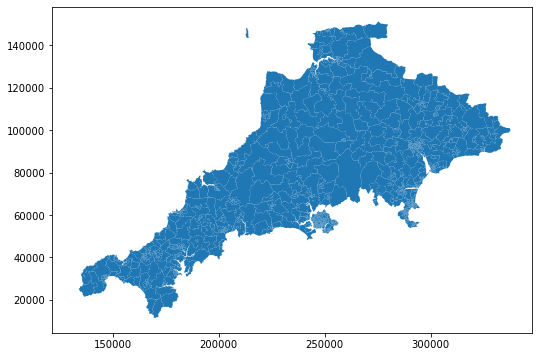

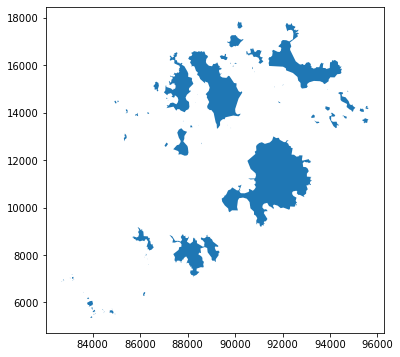

In [6]:
#create a separate GeoDataFrame for the LSOAs in Devon & Cornwall
region = "Cornwall|Devon|Torbay|Plymouth|Torridge|Teignbridge|Exeter"
mask = lsoa_gdf['LSOA11NM'].str.contains(region)
dc_lsoa_gdf = lsoa_gdf[mask]
dc_lsoa_gdf.plot(figsize=(12,6));

#and another GeoDataFrame for the LSOAs in the Isles of Scilly LSOAs
region = "Isles of Scilly"
mask = lsoa_gdf['LSOA11NM'].str.contains(region)
ios_lsoa_gdf = lsoa_gdf[mask]
ios_lsoa_gdf.plot(figsize=(12,6));

Matplotlib makes creating an inset map relatively straight forward using the `axes_grid1.inset_locator` module.  You have already imported what is needed at the start of this notebook using the code:

```python
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, 
                                                   InsetPosition,
                                                   mark_inset)
```

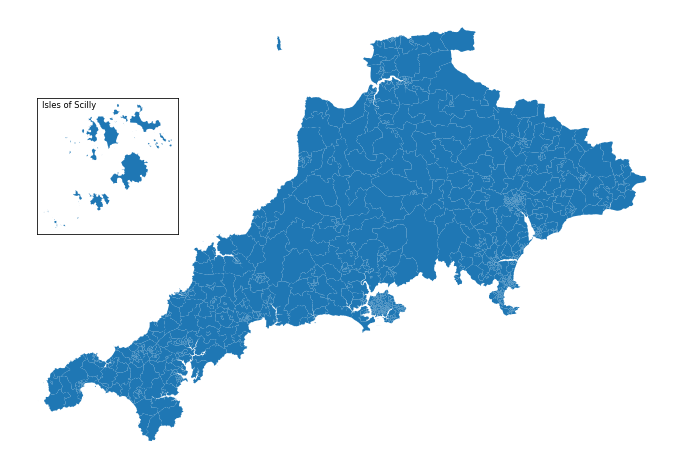

In [7]:
#create figure and main axes objects
fig, ax1 = plt.subplots(figsize=(12,12))

#plot main map
ax1 = dc_lsoa_gdf.plot(ax=ax1)

#create the inset map
ax2 = plt.axes([0,0,1,1])

#set the lower left x, y location and relative size of the bounding box
#note these are in fractional units.
ip = InsetPosition(ax1, [0.0,0.5,0.3,0.3])
ax2.set_axes_locator(ip)

#plot the Isle of Scilly inset
ax2 = ios_lsoa_gdf.plot(ax=ax2)

#manually place text within inset
#use the axes values in the above plot of the Isle of Scilly as a gauge
#for what values to use to get the required position
ax2.text(82500, 17500,'Isles of Scilly', fontsize='small')

#hide axis tick marks
ax2.tick_params(axis=u'both', which=u'both',length=0)

#hide axis lat long labels, but keep bounding box
ax2.set_xticklabels([])
ax2.set_yticklabels([])

#hide the box and axis labels
ax1.set_axis_off()

## Produce map with inset both displaying a field value

Let's imagine we want to display the value for the field "Area".

Let's see what the value range is for Area.

In [8]:
area_min = min(dc_lsoa_gdf.Area.min(),ios_lsoa_gdf.Area.min())
area_max = max(dc_lsoa_gdf.Area.max(),ios_lsoa_gdf.Area.max())

print(f"The min value for Area is: {area_min}")
print(f"The min value for Area is: {area_max}")

The min value for Area is: 85029
The min value for Area is: 218250768


If we are plotting values on the map (main and inset) then we need to make sure that the shading is consistent across both the main map and the inset.

To achieve this we need to set the colour range to be the full range across both GeoPandas DataFrames (Cornwall and Isles of Scilly). This is achieved by setting vmin and vmax in each of the plot methods.

The following code demonstrates how this works.

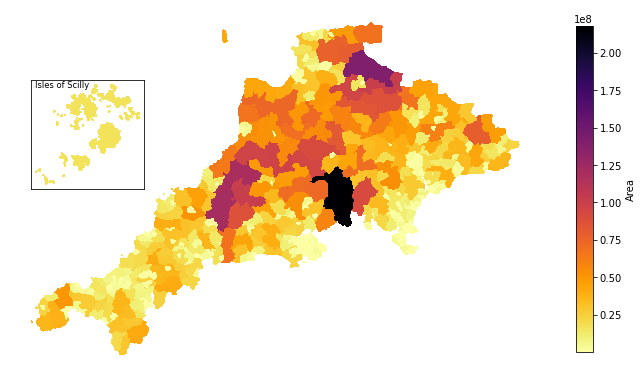

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, 
                                                   InsetPosition,
                                                   mark_inset)

#create figure and main axes objects
fig, ax1 = plt.subplots(figsize=(12,12))

#plot data (excluding the outlier)
ax1 = dc_lsoa_gdf.plot(antialiased=False, # Avoids artifact boundry lines
                            edgecolor='face', # Make LSOA boundry same colour as area
                            legend=True, 
                             vmin=area_min, # Manual scale min (remove to make automatic)
                             vmax=area_max, # Manual scale max (remove to make automatic)
                             cmap='inferno_r', # Colour map to use
                             legend_kwds={'shrink':0.5, 
                                          'label':'Area'},
                            column='Area',
                            ax=ax1)


#create the inset
ax2 = plt.axes([0,0,1,1])

#set the lower left x, y location and relative size of the bounding box
#note these are in fractional units.
ip = InsetPosition(ax1, [0.0,0.5,0.3,0.3])
ax2.set_axes_locator(ip)

#plot the Isle of Scilly LSOA inset
ax2 = ios_lsoa_gdf.plot(antialiased=False, # Avoids artifact boundry lines
                            edgecolor='face', # Make LSOA boundry same colour as area
                            legend=False, 
                             vmin=area_min, # Manual scale min (remove to make automatic)
                             vmax=area_max, # Manual scale max (remove to make automatic)
                             cmap='inferno_r', # Colour map to use
                            column='Area',
                            ax=ax2)

#manual text within inset
#use the axes values in the above Isle of Scilly plot as a gauge for what 
#values to use to get the required position
ax2.text(82500, 17500,'Isles of Scilly', fontsize='small')

#formatting tweaks...

#align legend left
leg = ax1.get_legend()

#hide axis tick marks
ax2.tick_params(axis=u'both', which=u'both',length=0)

#hide axis lat long labels, but keep bounding box
ax2.set_xticklabels([])
ax2.set_yticklabels([])

#hide the box and axis labels
ax1.set_axis_off()